In [18]:
# importing packages and modules
import pandas as pd 
import numpy as np
from pathlib import Path
import math
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats


In [19]:
trueP = np.zeros((2,2))
trueP[0,0]=0.97
trueP[0,1]=0.03
trueP[1,0]=.05
trueP[1,1]=.95
print("True Transition Matrix P")
print(trueP)

True Transition Matrix P
[[0.97 0.03]
 [0.05 0.95]]


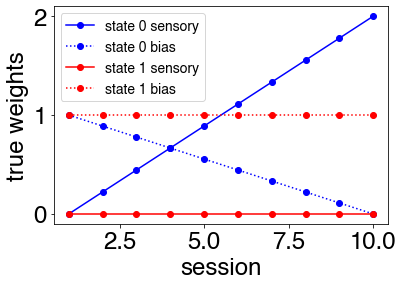

In [20]:
S = 10 # sessions
T = 500 # trials per session
N = T * S
C = 2 # classes
K = 2 # states
D = 2 # features (sensory & bias)
ourW = np.zeros((S,K,D))
ourW[:,0,0] = np.linspace(0,2,S) # state 1 sensory (increasing)
ourW[:,0,1] = np.linspace(1,0,S) # state 1 bias (decreasing)
ourW[:,1,0] = 0 # state 2 sensory (flat 0)
ourW[:,1,1] = 1 # state 2 bias (flat 1)
plt.plot(range(1,S+1),ourW[:,0,0],color='blue',marker='o',label='state 0 sensory')
plt.plot(range(1,S+1),ourW[:,0,1],color='blue',marker='o',linestyle=':',label='state 0 bias')
plt.plot(range(1,S+1),ourW[:,1,0],color='red',marker='o',label='state 1 sensory')
plt.plot(range(1,S+1),ourW[:,1,1],color='red',marker='o',linestyle=':',label='state 1 bias')
plt.ylabel("true weights")
plt.xlabel('session')
plt.legend(fontsize='xx-small')
plt.show()
trueW = np.zeros((N,K,D,C))
# change weight format to have session*trials points
for sess in range(0,S):
    for t in range(0,T):
        trueW[sess*T+t,:,:,1] = ourW[sess,:,:]



In [36]:
def emission_probability(x, w,  z=None, latents=False):
    '''
    Calculating emission probabilities for each session

    Parameters
    ----------
    x: N x D numpy array
    z: N x 1 numpy array
    w: N x K x D x C numpy array

    Returns
    -------
    phi: N x K x C numpy array
        emission probabilities
    '''
    N = x.shape[0]
    D = x.shape[1]
    K = w.shape[1]
    phi = np.empty((N,K,C)) # probability that it is state 1
    for k in range(0,K):
        for c in range(0,C):
            phi[:,k,c] = np.exp(-np.sum(x*w[:,k,:,c],axis=1))
        phi[:,k,:]  = np.divide((phi[:,k,:]).T,np.sum(phi[:,k,:],axis=1)).T     
    
    # np.sum()
    # if(plot==True):
    #     plt.title("histogram for emission probabilities of y_t=1")
    #     plt.hist(phi,[0,0.2,0.4,0.6,0.8,1])
    #     plt.show()
    

    return phi
phiSim = emission_probability(xSim, trueW,  z=None, latents=False)
print(phiSim)

# CHECKING WITH IRIS' CODE

In [23]:
def simulate_data(trueW, trueP,priorZstart,sess):
    '''
    function that simulates X and Y data from true weights and true transition matrix
    S sessions, K states, D features (in the order: sensory, bias)
    K = 2 BINOMIAL

    Parameters
    ----------
    trueW: S x K x D numpy array
        true weight matrix
    trueP: K X K numpy array
        true probability transition matrix
    priorZstart: int
        prior for initial latent state to be 0
        
    Returns
    -------
    x_sim: N x D
    y_sim: N x C
    z_sim: 

    '''

    # check that weights and transition matrix are valid options

    n = trueW.shape[0]
    k = trueW.shape[1] # states
    d = trueW.shape[2] # features
    c = trueW.shape[3]
    x = np.empty((n,d))
    y = np.empty((n,c))
    z = np.empty((n,),dtype=int)

    # input data x
    x[:,1] = 1 # bias term
    x[:,0] = stats.uniform.rvs(loc=-16,scale=33,size=n).astype(int)
    x[:,0] = x[:,0] - x[:,0].mean()
    x[:,0] = x[:,0] / x[:,0].std()

    # # latent variables z 
    # for t in range(0,n):
    #     if (t % trials==0): # beginning of session has a new draw for latent
    #         z[t] = np.random.binomial(n=1,p=1-priorZstart)
    #     else:
    #         z[t] = np.random.binomial(n=1, p=trueP[z[t-1],1])

    # for sess in range(0,s): # true weight are the same within one session
    #     # # choice/output data y
    #     # y[t] = np.random.binomial(n=1,p=1/(1+math.exp(-true_w[sess,])))

    # phi = emission_probability(x,z,w,plot=False)

    # for t in range(0,n):
    #     y[t] = np.random.binomial(n=1,p=phi[t])
    
    # print(z.sum())

    return x, y, z

xSim, _, _  = simulate_data(trueW=trueW, trueP=trueP, priorZstart=0.5, sess=500)

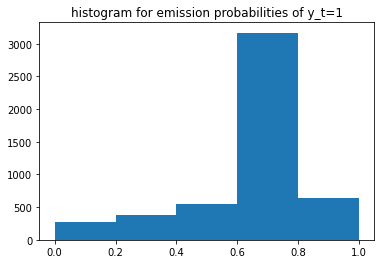

array([0.73105858, 0.73105858, 0.73105858, ..., 0.73105858, 0.73105858,
       0.73105858])

In [6]:
emission_probability(x_sim, z_sim, w_sim, plot=True)



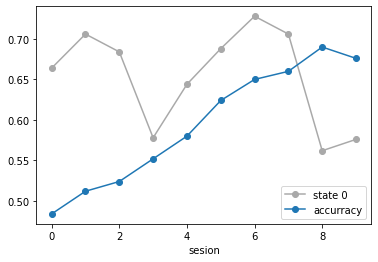

In [7]:
def accuracy(x,y,z,s):
    '''
    Calculates and plots percentage accuracy (given X and Y) and percentage accuracy in state 0 (given Z)

    X: N x D numpy array
    Y: N x 1 numpy array
    s: int
        number of sessions
    '''
    n = x.shape[0]
    perf = np.zeros((s,))
    trials = int(n/s)
    state0 = np.empty((s,))
    ind = []
    for sess in range(0,s):
        state0[sess] = trials - z_sim[sess*trials:(sess+1)*trials].sum()
        for t in range(0,trials):
            if (x[sess*trials+t,0]>0 and y[sess*trials+t]==1):
                perf[sess]+=1
            elif (x[sess*trials+t,0]<0 and y[sess*trials+t]==0):
                perf[sess]+=1
            else:
                ind.append(sess*trials+t)

    perf = perf / trials # normalize to number of trials per session
    state0 = state0 / trials
    plt.plot(range(0,s),state0,marker='o',color='darkgray',label='state 0')
    plt.plot(range(0,s),perf,marker='o',label="accurracy")
    plt.xlabel("sesion")
    plt.legend()
    plt.show()

    return perf, ind
perf,ind = accuracy(x_sim,y_sim,z_sim,s=10)

In [7]:
# Using Iris' code to fit simulate data and calculate alpha forward and backward

# Import outside packages by changing the path
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'glmhmm')))
from glmhmm import glm, glm_hmm, utils
from glmhmm.utils import permute_states, find_best_fit, compare_top_weights
from glmhmm import visualize, analysis

true_GLMHMM = glm_hmm.GLMHMM(N,D,C,K,observations="bernoulli")

inits = 1 # set the number of initializations

# store values for each initialization
lls_all = np.zeros((inits,250))
A_all = np.zeros((inits,K,K))
w_all = np.zeros((inits,K,D,C))

# fit the model for each initialization
A_init,w_init,pi_init = true_GLMHMM.generate_params() # initialize the model parameters
lls_all[0,:],A_all[0,:,:],w_all[0,:,:],pi0 = true_GLMHMM.fit(y_sim,x_sim,A_init,w_init,maxiter=1) # fit the model



-3234.832415737818
[[0.49994309 0.50005691]
 [0.50782564 0.49217436]
 [0.49963593 0.50036407]
 ...
 [0.41002458 0.58997542]
 [0.35864105 0.64135895]
 [0.36846614 0.63153386]]
[[0.5        0.5       ]
 [0.51522794 0.48477206]
 [0.5217031  0.4782969 ]
 ...
 [0.38186048 0.61813952]
 [0.44136397 0.55863603]
 [0.39915473 0.60084527]]
[0.59628475 0.59625009 0.59565863 ... 0.58647055 0.41592507 0.41007733]


In [8]:
print(w_init)

[[[0.         0.01830653]
  [0.         0.59404611]]

 [[0.         0.81900947]
  [0.         0.8031173 ]]]


In [8]:
def forward_pass(w,P):
    '''
    Calculates alpha scaled as part of the forward-backward algorithm in E-step for a single session 
    given current parameters weight w and transition matrix P

    Parameters
    ----------
    y : nx1 vector of observations
    P : kxk matrix of transition probabilities
    phi : nxkxc matrix of emission probabilities
        
    Returns
    -------
    ll : float, marginal log-likelihood of the data p(y)
    alpha : nx1 vector of the conditional probabilities p(z_t|x_{1:t},y_{1:t})
    cs : nx1 vector of the forward marginal likelihoods
    '''

1931
216


In [ ]:
# Iris' forward pass function
def forwardPass(self,y,A,phi,pi0=None):
        
        '''
        Computes forward pass of Expectation Maximization (EM) algorithm; first half of E-step.
        
        Parameters
        ----------
        y : nx1 vector of observations
        A : kxk matrix of transition probabilities
        phi : nxkxc matrix of emission probabilities
        
        Returns
        -------
        ll : float, marginal log-likelihood of the data p(y)
        alpha : nx1 vector of the conditional probabilities p(z_t|x_{1:t},y_{1:t})
        cs : nx1 vector of the forward marginal likelihoods
        '''
        
        alpha = np.zeros((y.shape[0],self.k)) # forward probabilities p(z_t | y_1:t)
        alpha_prior = np.zeros_like(alpha) # prior probabilities p(z_t | y_1:t-1)
        cs = np.zeros(y.shape[0]) # forward marginal likelihoods
        
        # if not fitting initial state probabilities, initialize to ones
        if not np.any(pi0):
            pi0 = np.ones(self.k)/self.k
            
        # if phi is 2d, add a time/trial axis (repeats matrix n times for stationary transitions)
        if len(phi.shape) == 2:
            phir = np.broadcast_to(phi, (y.shape[0], self.k, self.c))
        elif len(phi.shape) == 3:
            phir = phi
        
        # first time bin
        pxz = np.multiply(phir[0,:,int(y[0])],np.squeeze(pi0)) # weight t=0 observation probabilities by initial state probabilities
        cs[0] = np.sum(pxz) # normalizer

        alpha[0] = pxz/cs[0] # conditional p(z_1 | y_1)
        alpha_prior[0] = 1/self.k # conditional p(z_0 | y_0)
    
        # forward pass for remaining time bins
        for i in np.arange(1,y.shape[0]):
            alpha_prior[i] = alpha[i-1]@A # propogate uncertainty forward
            pxz = np.multiply(phir[i,:,int(y[i])],alpha_prior[i]) # joint P(y_1:t,z_t)
            cs[i] = np.sum(pxz) # conditional p(y_t | y_1:t-1)
            alpha[i] = pxz/cs[i] # conditional p(z_t | y_1:t)
        
        ll = np.sum(np.log(cs))
        
        return ll,alpha,alpha_prior,cs

In [ ]:
# Iris' fitting function

def fit(self,y,x,A,w,pi0=None,fit_init_states=False,maxiter=250,tol=1e-3,sess=None,B=1):
        '''
        Parameters
        ----------
        y : nx1 vector of observations 
        A : initial kxk matrix of transition probabilities
        phi : initial kxc or nxkxc matrix of emission probabilities
        pi0 : initial kx1 vector of state probabilities for t=1.
        fit_init_states : boolean, determines if EM will including fitting pi
        maxiter : int. The maximum number of iterations of EM to allow. The default is 250.
        tol : float. The tolerance value for the loglikelihood to allow early stopping of EM. The default is 1e-3.
        sessions : an optional vector of the first and last indices of different sessions in the data (for
        separate computations of the E step; first and last entries should be 0 and n, respectively)  
        B : an optional temperature parameter used when fitting via direct annealing EM (DAEM; see Ueda and Nakano 1998)                                                                                         
        Returns
        -------
        lls : vector of loglikelihoods for each step of EM, size maxiter 
        A : fitted kxk matrix of transition probabilities
        w : fitted kxdxc omatrix of weights
        pi0 : fitted kx1 vector of state probabilities for t= (only different from initial value of fit_init_states=True)
        '''
        
        self.lls = np.empty(maxiter)
        self.lls[:] = np.nan
            
        # store variables
        self.pi0 = pi0
        
        # # compute phi for each state from weights 
        phi = np.zeros((self.n,self.k,self.c))
        for i in range(self.n):
            for zi in range(self.k):
                phi[i,zi,:] = self.glm.observations.compObs(x[i,:],w[zi,:,:])
        
        if sess is None:
            sess = np.array([0,self.n]) # equivalent to saying the entire data set has one session
        
        for n in range(maxiter):
            
            # E STEP
            alpha = np.zeros((self.n,self.k))
            beta = np.zeros_like(alpha)
            cs = np.zeros((self.n))
            self.pStates = np.zeros_like(alpha)
            self.states = np.zeros_like(cs)
            ll = 0
            
            for s in range(len(sess)-1): # compute E step separately over each session or day of data 
                ll_s,alpha_s,_,cs_s = self.forwardPass(y[sess[s]:sess[s+1]],A,phi[sess[s]:sess[s+1],:,:],pi0=pi0)
                pBack_s,beta_s,zhatBack_s = self.backwardPass(y[sess[s]:sess[s+1]],A,phi[sess[s]:sess[s+1],:,:],alpha_s,cs_s)
                
                
                ll += ll_s
                alpha[sess[s]:sess[s+1]] = alpha_s
                cs[sess[s]:sess[s+1]] = cs_s
                self.pStates[sess[s]:sess[s+1]] = pBack_s ** B
                beta[sess[s]:sess[s+1]] = beta_s
                self.states[sess[s]:sess[s+1]] = zhatBack_s
                
            
            self.lls[n] = ll
            
            # M STEP
            A,w,phi,pi0 = self._updateParams(y,x,self.pStates,beta,alpha,cs,A,phi,w,fit_init_states = fit_init_states)
            
            
            # CHECK FOR CONVERGENCE    
            self.lls[n] = ll
            if  n > 5 and self.lls[n-5] + tol >= ll: # break early if tolerance is reached
                break
        
        self.A,self.w,self.phi,self.pi0 = A,w,phi,pi0

        return self.lls,self.A,self.w,self.pi0